# Feature Importance and Ablation Analysis

This analysis will seek to discover what features are most important to our Histogram-based Gradient Boosting Classification Model in two ways:
- Feature Importance Analysis (identify model weightings)
- Ablation Analysis (Understanding the contribution of certain features via their removal)

In [3]:
import pandas as pd
import numpy as np
import os

from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score

import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
sns.set_palette('rocket_r')

In [7]:
data = pd.read_csv('../../data/model_features.csv')
data.head()

,won,underdog,underdog_opp,fan_favorite,fan_favorite_opp,de,oe,te,pace,physicality_score,...,luck_opp,choke_rate,choke_rate_opp,upset_rate,upset_rate_opp,3mean_plus_minus,3mean_plus_minus_opp,win_streak,win_streak_opp,matchup_win_rate
0,1,0,0,1,0,83.955939,105.172414,1.25271,72.0,9.405172,...,0.000000,0.0,NaN,0.0,NaN,14.333333,-3.333333,0,0,NaN
1,1,0,0,0,1,83.955939,105.172414,1.25271,72.0,9.405172,...,0.571429,0.0,NaN,0.0,NaN,14.333333,-0.333333,1,2,NaN
2,1,0,0,1,0,83.955939,105.172414,1.25271,72.0,9.405172,...,0.444444,0.0,NaN,0.0,0.000000,14.333333,-5.666667,2,1,NaN
3,1,0,0,1,0,83.955939,105.172414,1.25271,72.0,9.405172,...,0.000000,0.0,NaN,0.0,NaN,14.333333,-10.333333,3,0,0.5
4,0,1,0,0,1,83.955939,105.172414,1.25271,72.0,9.405172,...,0.333333,0.0,0.3,0.0,0.444444,13.666667,21.333333,4,2,NaN


In [9]:
data.shape

(39518, 84)

In [10]:
def get_odds_ratios(model):
    # Build a dataframe with odds ratios and their confidence intervals.
    params = model.params
    odds_ratios = pd.DataFrame(
        {
            "OR": params
        }
    )
    # Exponentiate the data frame
    odds_ratios = np.exp(odds_ratios)

    print('\nOdds Ratios:')
    print(odds_ratios.sort_values('OR',ascending=False))
    
    # Print prediction table
    if type(model) not in [type(LogisticRegression()), type(XGBClassifier())]:
        print('\nPrediction table:')
        print(model.pred_table())
    
    return None

### Feature Importance of Gradient Boosting Classifier

The feature_importance attribute is not supported for Histogram-based Gradient Boosting, but it is for a standard Gradient Boosting model. We will extract our top 20 most important features using Gradient Boosting, to be used in the Ablation Analysis

In [11]:
# Split training and test data
df = data.fillna(0)

X = df.iloc[:,1:]
y = df.iloc[:,0]

GB_model = GradientBoostingClassifier()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for scaler in [StandardScaler(), MinMaxScaler()]:
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

GB_model.fit(X_train, y_train)

GradientBoostingClassifier()

In [12]:
feature_importance = {
    key:[value] for key,value in sorted(zip(data.columns.tolist()[1:], GB_model.feature_importances_), key=lambda x: x[1], reverse=True)}

df_gb_importance = pd.DataFrame(feature_importance,index=['feature_importance']).T
df_gb_importance.index.name = 'feature'

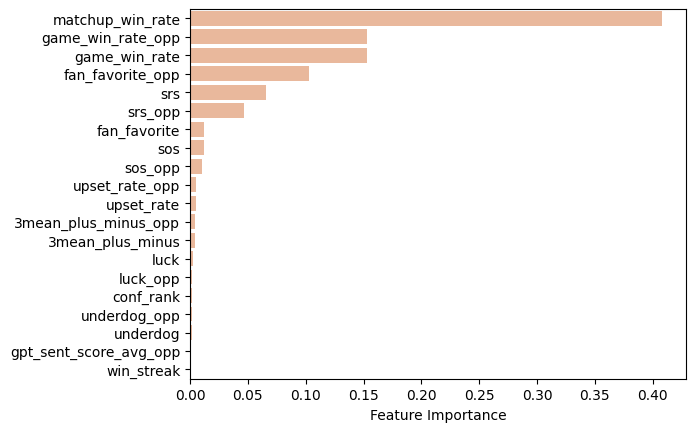

In [18]:
top_n = 20
top_df = df_gb_importance.iloc[:top_n]
sns.barplot(top_df, y=top_df.index, x='feature_importance')

# plt.title(f'Figure 2 - Gradient Boosting Classifier Feature Importance (Top {top_n})')
plt.ylabel(None)
plt.xlabel('Feature Importance')
plt.savefig('../../visuals/gradient_boosting_classifier_feature_importance.png',bbox_inches='tight')

## Ablation Analysis using Histogram-based Gradient Boosting Classification Model

In [68]:
# Set baseline f1-score

df = data.copy()

# Split training and test data
X = df.iloc[:,1:]
y = df.iloc[:,0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for scaler in [StandardScaler(), MinMaxScaler()]:
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

model = HistGradientBoostingClassifier(
    learning_rate = 0.05,
    min_samples_leaf = 25,
    random_state=42)

# Train the model on the training set
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

baseline_f1 = f1_score(y_test, y_pred)
print(f'Baseline F1-score: {baseline_f1}')

Baseline F1-score: 0.791757327531038


In [77]:
top_features = list(feature_importance.keys())[:top_n]

f1_score_impacts = {}
for feature in data.columns[1:]:
    df = data.drop(feature, axis=1)

    # Split training and test data
    X = df.iloc[:,1:]
    y = df.iloc[:,0]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    for scaler in [StandardScaler(), MinMaxScaler()]:
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    model = HistGradientBoostingClassifier(
        learning_rate = 0.05,
        min_samples_leaf = 25,
        random_state=42)
    
    # Train the model on the training set
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)

    f1 = f1_score(y_test, y_pred)
    f1_score_impacts[feature] = [f1, baseline_f1, f1 - baseline_f1]

In [16]:
feature_impacts_filepath = '../../data/feature_impacts.csv'
if not os.path.exists(feature_impacts_filepath):
    feature_f1_impacts = pd.DataFrame(f1_score_impacts, index=['F1-score','Baseline F1-score','Feature Impact']).T
    feature_f1_impacts.to_csv(feature_impacts_filepath)
else:
    feature_f1_impacts = pd.read_csv(feature_impacts_filepath).set_index('Unnamed: 0')
top_impacters = feature_f1_impacts.sort_values('Feature Impact').head(top_n)
top_impacters

,F1-score,Baseline F1-score,Feature Impact
Unnamed: 0,,,
matchup_win_rate,0.764415,0.791757,-0.027342
game_win_rate,0.786852,0.791757,-0.004906
game_win_rate_opp,0.789040,0.791757,-0.002717
ast_per_poss_opp,0.789724,0.791757,-0.002033
underdog_opp,0.789864,0.791757,-0.001893
tov_per_poss_opp,0.790221,0.791757,-0.001536
ast_per_poss,0.790275,0.791757,-0.001482
pf_opp,0.790288,0.791757,-0.001470
oe_opp,0.790294,0.791757,-0.001464


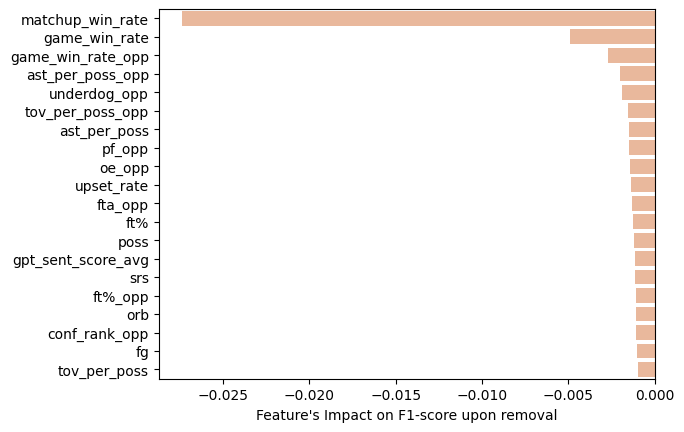

In [19]:
sns.barplot(top_impacters, y=top_impacters.index, x='Feature Impact')

# plt.title(f'Figure 3 - Ablation Analysis - Features that most impacted f1-score (Top {top_n})')
plt.ylabel(None)
plt.xlabel('Feature\'s Impact on F1-score upon removal')

plt.savefig('../../visuals/ablation_analysis.png', bbox_inches='tight')

### See the percentage of features that intersect between the GBClassifier feature_importance and Ablation analysis

In [94]:

intersections = 0
for feature in top_impacters.index:
    if feature in top_df.index:
        intersections += 1

print(intersections / top_n)

0.3


### Try model while dropping all features with a negative impact

In [85]:
hindering_features = feature_f1_impacts.loc[feature_f1_impacts['Feature Impact'] > 0].index.tolist()
hindering_features

['fan_favorite',
 'fan_favorite_opp',
 'oe',
 'pace',
 'physicality_score',
 'sos',
 'fg%',
 '3p',
 '3pa',
 '3p%',
 'ft',
 'drb',
 'trb',
 'ast',
 'stl',
 'blk',
 'pf',
 'tov%',
 'ast_per_fg',
 'de_opp',
 'te_opp',
 'physicality_score_opp',
 'sos_opp',
 'fg_opp',
 'fga_opp',
 '3pa_opp',
 'ft_opp',
 'drb_opp',
 'trb_opp',
 'stl_opp',
 'blk_opp',
 'tov%_opp',
 'poss_opp',
 'gpt_sent_score_avg_opp',
 'luck',
 'luck_opp',
 'choke_rate',
 'choke_rate_opp',
 '3mean_plus_minus',
 '3mean_plus_minus_opp',
 'win_streak_opp']

In [86]:
df = data.drop(hindering_features, axis=1)

# Split training and test data
X = df.iloc[:,1:]
y = df.iloc[:,0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for scaler in [StandardScaler(), MinMaxScaler()]:
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

model = HistGradientBoostingClassifier(
    learning_rate = 0.05,
    min_samples_leaf = 25,
    random_state=42)

# Train the model on the training set
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

f1 = f1_score(y_test, y_pred)
print(f'Revised Features F1-score: {f1}')

Revised Features F1-score: 0.7782201104404777
